In [1]:
### Imports

import os
from pathlib import Path
from rosbags.highlevel import AnyReader
from rosbags.image import message_to_cvimage
from rosbags.typesys import Stores, get_typestore
from rosbags.rosbag1 import Reader
from rosbags.typesys import get_typestore, Stores
typestore = get_typestore(Stores.ROS1_NOETIC)  # or ROS1_MELODIC if appropriate
import re

import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import random
import matplotlib.image as mpimg
from IPython.display import display, Markdown
import math
import matplotlib.patches as patches
from collections import defaultdict
from matplotlib import colormaps
from sklearn.cluster import DBSCAN
import scipy.io as sio


In [2]:
### Functions to extract images and poses from bag files *********************************

STATUS_REGEX = re.compile(r'"status"\s*:\s*"(\w+)"')

def extract_status_fallback(raw_data):
    """Try to extract 'status' using regex from malformed JSON."""
    match = STATUS_REGEX.search(raw_data)
    return match.group(1) if match else None

def get_task_status(bag_path, topic_name='/task_executor/task/feedback'):
    last_status = None
    try:
        with Reader(bag_path) as reader:
            connections = [c for c in reader.connections if c.topic == topic_name]

            for conn, timestamp, rawdata in reader.messages(connections=connections):
                msg = typestore.deserialize_cdr(rawdata, conn.msgtype)
                try:
                    raw_data = msg.data.strip()

                    if not rawdata or len(rawdata) < 4:
                        print(f"Skipping empty or malformed rawdata in {file_name}")
                        continue

                    status = None
                
                    if raw_data.startswith('"') and raw_data.endswith('"'):
                        raw_data = json.loads(raw_data)
                    parsed = json.loads(raw_data)
                    status = parsed.get("status")
                except Exception:
                    status = extract_status_fallback(raw_data)

                if status:
                    last_status = status

    except Exception as e:
        print(f"Error processing {bag_path}: {e}")

    if last_status == "SUCCESS":
        return True
    else:
        return False
    
def extract_poses_from_bag(bags_root, bag_name, bag_path, task_output_root, pose_file_name):
    pose_output_path = os.path.join(task_output_root, pose_file_name)
    bagpath = Path(bag_path)
    typestore = get_typestore(Stores.ROS1_NOETIC)
    with AnyReader([bagpath], default_typestore=typestore) as reader, open(pose_output_path, 'w') as pose_output_file:
        header = "timestamp x y theta\n"
        pose_output_file.write(header)

        # Find the connection for the topic
        connections = [x for x in reader.connections if x.topic == "/amcl_pose"]

        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = reader.deserialize(rawdata, connection.msgtype)
            t = int(timestamp / 1e9)  # nanoseconds to seconds
            pos = msg.pose.pose.position
            ori = msg.pose.pose.orientation
            line = f"{t} {pos.x:.5f} {pos.y:.5f} {ori.z:.5f}\n"
            pose_output_file.write(line)
    #print("Pose extraction completed.")

def extract_images_from_bag(bags_root, bag_name, bag_path, task_output_root):
    bagpath = Path(bag_path)
    typestore = get_typestore(Stores.ROS1_NOETIC)

    topic_suffixes = {
        '/realsense_torso_front_camera/color/image_raw_throttle': '_t',
        '/realsense_front_camera/color/image_raw_throttle': '_f',
        '/realsense_left_camera/color/image_raw_throttle': '_l',
        '/realsense_right_camera/color/image_raw_throttle': '_r'
    }

    with AnyReader([bagpath], default_typestore=typestore) as reader:
        connections = [x for x in reader.connections if x.topic in topic_suffixes]
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = reader.deserialize(rawdata, connection.msgtype)
            # Convert ROS image message to OpenCV image
            img = message_to_cvimage(msg, 'bgr8')
            t = int(timestamp / 1e9)  # nanoseconds to seconds
            suffix = topic_suffixes[connection.topic]
            img_name = f"{t}{suffix}.jpg"
            img_output_path = os.path.join(task_output_root, img_name)
            cv2.imwrite(img_output_path, img)
    #print("Image extraction completed.")
    
def extract_imu_from_bag(bags_root, bag_name, bag_path, task_output_root, imu_file_name):
    imu_output_path = os.path.join(task_output_root, imu_file_name)
    bagpath = Path(bag_path)
    typestore = get_typestore(Stores.ROS1_NOETIC)

    with AnyReader([bagpath], default_typestore=typestore) as reader, open(imu_output_path, 'w') as imu_output_file:
        header = "timestamp orientation_x orientation_y orientation_z orientation_w angular_vel_x angular_vel_y angular_vel_z linear_acc_x linear_acc_y linear_acc_z\n"
        imu_output_file.write(header)
        connections = [x for x in reader.connections if x.topic == "/smart_wheel_driver/pdb/imu"]

        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = reader.deserialize(rawdata, connection.msgtype)
            t = int(timestamp / 1e9)  # nanoseconds to seconds
            ori = msg.orientation
            ang = msg.angular_velocity
            lin = msg.linear_acceleration
            line = (
                f"{t} "
                f"{ori.x:.6f} {ori.y:.6f} {ori.z:.6f} {ori.w:.6f} "
                f"{ang.x:.6f} {ang.y:.6f} {ang.z:.6f} "
                f"{lin.x:.6f} {lin.y:.6f} {lin.z:.6f}\n"
            )
            imu_output_file.write(line)
    #print("IMU extraction completed.")
    
def extract_bags(input_root, output_root, pose_file_name, imu_file_name, task_filter=True):
    for bag_name in os.listdir(input_root):
        if bag_name.endswith('.bag'):
            bag_name_noext, ext = os.path.splitext(bag_name)
            short_bag_name = bag_name_noext[:41]
            bag_path = os.path.join(input_root, bag_name)
            
            task_output_root = os.path.join(output_root, short_bag_name)
            
            if(task_filter):
                if(get_task_status(bag_path)):
                    os.makedirs(task_output_root, exist_ok=True)
                    extract_images_from_bag(input_root, bag_name, bag_path, task_output_root)
                    extract_poses_from_bag(input_root, bag_name, bag_path, task_output_root, pose_file_name)
                    extract_imu_from_bag(input_root, bag_name, bag_path, task_output_root, imu_file_name)
            else:
                os.makedirs(task_output_root, exist_ok=True)
                extract_images_from_bag(input_root, bag_name, bag_path, task_output_root)
                extract_poses_from_bag(input_root, bag_name, bag_path, task_output_root, pose_file_name)
                extract_imu_from_bag(input_root, bag_name, bag_path, task_output_root, imu_file_name)

In [3]:
### Functions to average poses to match camera frames ************************************

def avg_poses(dataset_root, pose_file_name, avg_pose_file_name):
    for dirpath, dirnames, filenames in os.walk(dataset_root):
        if pose_file_name in filenames:
            task_pose_file_path = os.path.join(dirpath, pose_file_name)
            task_avg_pose_file_path = os.path.join(dirpath, avg_pose_file_name)
            process_poses_file(task_pose_file_path, task_avg_pose_file_path)
            
def process_poses_file(task_pose_file_path, task_avg_pose_file_path):
    # Dictionary: timestamp -> list of [x, y, z]
    poses_dict = {}
    with open(task_pose_file_path, 'r') as f:
        header = f.readline()
        for line in f:
            tokens = line.strip().split()
            if len(tokens) < 4:
                continue
            timestamp = tokens[0]
            values = [float(tokens[1]), float(tokens[2]), float(tokens[3])]
            poses_dict.setdefault(timestamp, []).append(values)
    
    with open(task_avg_pose_file_path, 'w') as f:
        f.write("timestamp x y theta\n")
        for timestamp in sorted(poses_dict.keys()):
            arr = np.array(poses_dict[timestamp])
            avg = arr.mean(axis=0)
            f.write(f"{timestamp} {avg[0]:.5f} {avg[1]:.5f} {avg[2]:.5f}\n")

In [4]:
### Functions to output image pose and place pairs ***************************************

def parse_poses_file(poses_path):
    poses = {}
    with open(poses_path, "r") as f:
        header = f.readline()
        for line in f:
            tokens = line.strip().split()
            if len(tokens) < 4:
                continue
            timestamp = tokens[0]
            position = [float(tokens[1]), float(tokens[2]), float(tokens[3])]
            poses[timestamp] = position
    return poses

def timestamp_from_filename(filename):
    base = os.path.basename(filename)
    return base.split('_')[0]

def merge_images_and_poses(dataset_root, avg_pose_file_name, output_file):
    rows = []
    for dirpath, dirnames, filenames in os.walk(dataset_root):
        if avg_pose_file_name in filenames:
            poses_path = os.path.join(dirpath, avg_pose_file_name)
            poses = parse_poses_file(poses_path)
            images = glob.glob(os.path.join(dirpath, "*.jpg"))
            for img in images:
                ts = timestamp_from_filename(img)
                if ts in poses:
                    rel_img_path = os.path.relpath(img, dataset_root)
                    x, y, theta = poses[ts]
                    rows.append(f"{rel_img_path} {x} {y} {theta}")
                    
    with open(output_file, "w") as f:
        f.write("image_path x y theta\n")
        for row in rows:
            f.write(row + "\n")

In [5]:
### Functions to filter images based on their brightness *********************************

def compute_brightness(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    return img.mean()
    
def is_valid_image(file_path, min_brightness, max_brightness):
    if not os.path.exists(file_path):
        return False
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return False
    mean_brightness = img.mean()
    return min_brightness <= mean_brightness <= max_brightness    

def plot_brightness(dataset_root, file_path, image_col_index=0, delimiter=' '):
    brightness_values = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(delimiter)
            if len(parts) <= image_col_index:
                continue

            rel_path = parts[image_col_index]
            full_path = os.path.join(dataset_root, rel_path)
            if not os.path.exists(full_path):
                continue

            brightness = compute_brightness(full_path)
            if brightness is not None:
                brightness_values.append(brightness)
                
    plt.hist(brightness_values, bins=50, color='skyblue', edgecolor='black')
    plt.title("Image Brightness Distribution")
    plt.xlabel("Mean Brightness (0 = dark, 255 = bright)")
    plt.ylabel("Number of Images")
    plt.grid(True)
    plt.show()  
    return brightness_values

def count_suffixes(file_path):
    suffix_map = {
        '_t': 'Torso',
        '_f': 'Front',
        '_r': 'Right',
        '_l': 'Left'
    }
    counts = {group: 0 for group in suffix_map.values()}
    row_count = 0 
    
    with open(file_path, 'r') as f:
        for line in f:
            columns = line.strip().split()
            if not columns:
                continue
            row_count += 1
            image_path = columns[0]
            filename = os.path.basename(image_path)
            name, ext = os.path.splitext(filename)
            for suf, group in suffix_map.items():
                if name.endswith(suf):
                    counts[group] += 1
                    break
    return counts, row_count

def plot_pie(counts):
    labels = []
    sizes = []
    for k, v in counts.items():
        if v > 0:
            labels.append(k)
            sizes.append(v)
    if not sizes:
        print("No images with the expected suffixes were found. Nothing to plot.")
        return
    plt.figure(figsize=(3, 3))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Camera Samples')
    plt.axis('equal')
    plt.show()
    
def filter_images(input_root, image_pose_path, filtered_image_pose_path):
    counts, row_count = count_suffixes(image_pose_path)
    print("Before filtering: {:,}".format(row_count))
    brightness_values = plot_brightness(input_root, image_pose_path)
    #plot_pie(counts)

    # First option using mean and std
    brightness_mean = np.mean(brightness_values) 
    brightness_std = np.std(brightness_values)
    min_brightness = brightness_mean-2*brightness_std
    max_brightness = brightness_mean+2*brightness_std

    # Second option using percentile is more robust to outliers 
    #min_brightness = np.percentile(brightness_values, 5)
    #max_brightness = np.percentile(brightness_values, 90)

    print("Filtering in progress")
    
    image_col_index = 0
    delimiter = ' '
    with open(image_pose_path, 'r') as infile, open(filtered_image_pose_path, 'w') as outfile:
        outfile.write("timestamp x y theta\n")
        for line in infile:
            parts = line.strip().split(delimiter)
            if len(parts) <= image_col_index:
                continue
            rel_path = parts[image_col_index]
            full_path = os.path.join(input_root, rel_path)
            if is_valid_image(full_path, min_brightness, max_brightness):
                outfile.write(line)
                
    print("Finished image filtering")

    counts, row_count = count_suffixes(filtered_image_pose_path)
    print("After filtering: {:,}".format(row_count))
    #plot_brightness(input_root, filtered_image_pose_path)
    #plot_pie(counts)


In [6]:
### Functions to generate place_id for each grid cell and plot them **********************
### Functions to plot poses **************************************************************

def generate_place_ids(input_file, output_file, grid_size, has_header=True):
    place_id_map = {}
    next_place_id = 0
    output_lines = []

    with open(input_file, 'r') as infile:
        lines = infile.readlines()

    start_idx = 1 if has_header else 0
    data_lines = lines[start_idx:]

    for line_num, line in enumerate(data_lines, start=start_idx + 1):
        if not line.strip():
            continue 

        parts = line.strip().split()

        image_path, x_str, y_str, theta_str = parts
        x = float(x_str)
        y = float(y_str)

        grid_x = math.floor(x / grid_size)
        grid_y = math.floor(y / grid_size)
        grid_key = (grid_x, grid_y)

        if grid_key not in place_id_map:
            place_id_map[grid_key] = next_place_id
            next_place_id += 1

        place_id = place_id_map[grid_key]
        output_lines.append(f"{image_path} {x} {y} {theta_str} {place_id}\n")

    with open(output_file, 'w') as outfile:
        if has_header:
            outfile.write("image_path x y theta place_id\n")
        outfile.writelines(output_lines)

    print(f"Processed {len(output_lines)} entries with {next_place_id} unique place_ids.")

def generate_place_ids_dbscan(input_file, output_file, eps=4.0, min_samples=1, has_header=True):
    poses = []
    image_paths = []
    thetas = []

    with open(input_file, 'r') as infile:
        lines = infile.readlines()
        
    start_idx = 1 if has_header else 0
    data_lines = lines[start_idx:]

    for line_num, line in enumerate(data_lines, start=start_idx + 1):
        if not line.strip():
            continue

        parts = line.strip().split()
        if len(parts) != 4:
            print(f"Skipping malformed line {line_num}: {line.strip()}")
            continue

        image_path, x_str, y_str, theta_str = parts
        try:
            x = float(x_str)
            y = float(y_str)
        except ValueError:
            print(f"Skipping line with non-numeric coordinates at line {line_num}")
            continue

        image_paths.append(image_path)
        poses.append([x, y])
        thetas.append(theta_str)

    if not poses:
        print("No valid poses found.")
        return

    poses_np = np.array(poses)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(poses_np)

    output_lines = []
    for idx, label in enumerate(labels):
        output_lines.append(f"{image_paths[idx]} {poses_np[idx,0]} {poses_np[idx,1]} {thetas[idx]} {label}\n")

    with open(output_file, 'w') as outfile:
        if has_header:
            outfile.write("image_path x y theta place_id\n")
        outfile.writelines(output_lines)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Processed {len(output_lines)} entries with {n_clusters} unique place_ids (DBSCAN).")
    
def plot_place_ids(input_file, grid_size, fig_width=25, fig_height=4, dpi=200):
    data = []

    with open(input_file, 'r') as f:
        lines = f.readlines()

    if lines[0].strip().startswith("image_path"):
        lines = lines[1:]

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue

        _, x_str, y_str, _, place_id_str = parts
        try:
            x = float(x_str)
            y = float(y_str)
            place_id = int(place_id_str)
        except ValueError:
            continue

        data.append((x, y, place_id))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)

    xs = [x for x, _, _ in data]
    ys = [y for _, y, _ in data]
    ax.scatter(xs, ys, color='gray', s=1, alpha=0.5)

    seen_cells = set()
    for x, y, place_id in data:
        grid_x = math.floor(x / grid_size)
        grid_y = math.floor(y / grid_size)
        cell_key = (grid_x, grid_y)

        if cell_key in seen_cells:
            continue
        seen_cells.add(cell_key)

        rect = patches.Rectangle(
            (grid_x * grid_size, grid_y * grid_size),
            grid_size,
            grid_size,
            linewidth=1,
            edgecolor='black',
            facecolor='none'
        )
        ax.add_patch(rect)

        center_x = (grid_x + 0.5) * grid_size
        center_y = (grid_y + 0.5) * grid_size
        ax.text(center_x, center_y, str(place_id),
                fontsize=8, ha='center', va='center', alpha=0.4)

    margin = grid_size * 0.5
    ax.set_xlim(min(xs) - margin, max(xs) + margin)
    ax.set_ylim(min(ys) - margin, max(ys) + margin)
    ax.set_aspect('equal')
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.set_title("Grid Cells with Place IDs", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

def read_poses_avg(file_path):
    xs, ys, zs = [], [], []
    with open(file_path, 'r') as f:
        header = f.readline()
        for line in f:
            tokens = line.strip().split()
            if len(tokens) < 4:
                continue
            xs.append(float(tokens[1]))
            ys.append(float(tokens[2]))
            zs.append(float(tokens[3]))
    return np.array(xs), np.array(ys), np.array(zs)

def plot_orientations(xs, ys, zs, color, label, scale=0.5):
    plt.plot(xs, ys, marker='o', color=color, label=label)
    for x, y, z in zip(xs, ys, zs):
        dx = scale * np.cos(z)
        dy = scale * np.sin(z)
        plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc=color, ec=color, alpha=0.6)

def plot_poses(dataset_root, avg_pose_file_name, fig_width=25, fig_height=4, dpi=200):
    plt.figure(figsize=(fig_width, fig_height))
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_idx = 0

    for dirpath, dirnames, filenames in os.walk(dataset_root):
        if avg_pose_file_name in filenames:
            file_path = os.path.join(dirpath, avg_pose_file_name)
            xs, ys, zs = read_poses_avg(file_path)
            label = os.path.relpath(dirpath, dataset_root)
            color = color_cycle[color_idx % len(color_cycle)]
            plot_orientations(xs, ys, zs, color, label)
            color_idx += 1

    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.title("Overlayed Average Poses from All Tasks")
    #plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

In [7]:
### Functions to create the ground truth *************************************************

def get_suffix(path):
    filename = os.path.basename(path)
    return filename.split('_')[-1].split('.')[0]

def get_folder(path):
    return path.split('/')[0]  # task_id

def get_timestamp(path):
    filename = os.path.basename(path)
    ts_str = filename.split('_')[0]
    return int(ts_str)

def generate_triplets_by_pose(text_file_path, camera_matching, task_matching, date_matching, POSITIVE_DISTANCE_THRESHOLD, NEGATIVE_DISTANCE_THRESHOLD):
    # Load data
    all_images = []
    with open(text_file_path, 'r') as f:
        for line in f:
            if not line.strip() or line.startswith("image_path"):
                continue
            parts = line.strip().split()
            img_path, x, y, theta, place_id = parts[0], float(parts[1]), float(parts[2]), float(parts[3]), parts[4]
            all_images.append({
                "path": img_path,
                "position": np.array([x, y]),
                "theta": theta,
                "place_id": place_id,
                "folder": get_folder(img_path),
                "suffix": get_suffix(img_path),
                "timestamp": get_timestamp(img_path),
                "day": get_timestamp(img_path) // 86400,
            })

    # Convert to numpy arrays for fast filtering
    positions = np.array([img["position"] for img in all_images])
    paths = np.array([img["path"] for img in all_images])
    suffixes = np.array([img["suffix"] for img in all_images])
    folders = np.array([img["folder"] for img in all_images])
    timestamps = np.array([img["timestamp"] for img in all_images])
    days = np.array([img["day"] for img in all_images])

    triplets = []

    for i, anchor in enumerate(all_images):
        anchor_pos = anchor["position"]
        anchor_path = anchor["path"]
        anchor_suffix = anchor["suffix"]
        anchor_folder = anchor["folder"]
        anchor_day = anchor["day"]

        mask = np.ones(len(all_images), dtype=bool)
        mask[i] = False

        if camera_matching:
            mask &= (suffixes == anchor_suffix)
        else:
            mask &= (suffixes != anchor_suffix)

        if task_matching:
            mask &= (folders == anchor_folder)
        else:
            mask &= (folders != anchor_folder)

        if date_matching:
            mask &= (days == anchor_day)
        else:
            mask &= (days != anchor_day)

        candidate_idx = np.where(mask)[0]
        if len(candidate_idx) == 0:
            continue

        candidate_positions = positions[candidate_idx]
        dists = np.linalg.norm(candidate_positions - anchor_pos, axis=1)

        pos_mask = (dists > 0) & (dists <= POSITIVE_DISTANCE_THRESHOLD)
        neg_mask = (dists >= NEGATIVE_DISTANCE_THRESHOLD)

        pos_candidates = paths[candidate_idx[pos_mask]]
        neg_candidates = paths[candidate_idx[neg_mask]]

        if len(pos_candidates) > 0 and len(neg_candidates) > 0:
            pos_path = random.choice(pos_candidates)
            neg_path = random.choice(neg_candidates)
            triplets.append((anchor_path, pos_path, neg_path))

    return triplets

def generate_triplets_by_place(text_file_path, camera_matching, task_matching, date_matching):
    # Load data
    all_images = []
    with open(text_file_path, 'r') as f:
        for line in f:
            if not line.strip() or line.startswith("image_path"):
                continue
            parts = line.strip().split()
            img_path, x, y, theta, place_id = parts[0], float(parts[1]), float(parts[2]), float(parts[3]), parts[4]
            all_images.append({
                "path": img_path,
                "place_id": place_id,
                "folder": get_folder(img_path),
                "suffix": get_suffix(img_path),
                "timestamp": get_timestamp(img_path),
                "day": get_timestamp(img_path) // 86400,
            })

    # Precompute arrays
    paths = np.array([img["path"] for img in all_images])
    place_ids = np.array([img["place_id"] for img in all_images])
    folders = np.array([img["folder"] for img in all_images])
    suffixes = np.array([img["suffix"] for img in all_images])
    days = np.array([img["day"] for img in all_images])

    triplets = []

    for i, anchor in enumerate(all_images):
        anchor_path = anchor["path"]
        anchor_place = anchor["place_id"]
        anchor_suffix = anchor["suffix"]
        anchor_folder = anchor["folder"]
        anchor_day = anchor["day"]

        mask = np.ones(len(all_images), dtype=bool)
        mask[i] = False

        if camera_matching:
            mask &= (suffixes == anchor_suffix)
        else:
            mask &= (suffixes != anchor_suffix)

        if task_matching:
            mask &= (folders == anchor_folder)
        else:
            mask &= (folders != anchor_folder)

        if date_matching:
            mask &= (days == anchor_day)
        else:
            mask &= (days != anchor_day)

        candidate_idx = np.where(mask)[0]
        if len(candidate_idx) == 0:
            continue

        pos_idx = candidate_idx[place_ids[candidate_idx] == anchor_place]
        neg_idx = candidate_idx[place_ids[candidate_idx] != anchor_place]

        if len(pos_idx) > 0 and len(neg_idx) > 0:
            pos_path = random.choice(paths[pos_idx])
            neg_path = random.choice(paths[neg_idx])
            triplets.append((anchor_path, pos_path, neg_path))

    return triplets

In [8]:
### Functions to split the dataset *******************************************************

def split_dataset(input_file, output_dir, mode, train_name, test_name, val_name):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    header = lines[0]
    data_lines = lines[1:]

    processed_lines = []
    for line in data_lines:
        if not line.strip():
            continue
        parts = line.strip().split()

        parts[0] = os.path.join(mode, parts[0])
        processed_lines.append(' '.join(parts) + '\n')

    random.shuffle(processed_lines)

    total = len(processed_lines)
    train_end = int(0.7 * total)
    test_end = train_end + int(0.2 * total)

    train_lines = processed_lines[:train_end]
    test_lines = processed_lines[train_end:test_end]
    val_lines = processed_lines[test_end:]

    os.makedirs(output_dir, exist_ok=True)

    with open(os.path.join(output_dir, train_name), 'w') as f:
        f.writelines(train_lines)

    with open(os.path.join(output_dir, test_name), 'w') as f:
        f.writelines(test_lines)

    with open(os.path.join(output_dir, val_name), 'w') as f:
        f.writelines(val_lines)
        
def convert_txts_to_mat(input_dir, pos_dist_thr=0.1):
    """
    Converts 6 text files in a directory to 3 .mat files (train, val, test).
    Each text file should have lines: image_path x y theta place_id

    Args:
        input_dir (str): Directory containing the 6 text files.
        pos_dist_thr (float): Positive distance threshold.
    """

    sets = {
        'train': ('train_database.txt', 'train_query.txt', 'lw_train.mat'),
        'val': ('val_database.txt', 'val_query.txt', 'lw_val.mat'),
        'test': ('test_database.txt', 'test_query.txt', 'lw_test.mat')
    }

    for split, (db_file, q_file, mat_file) in sets.items():
        db_path = os.path.join(input_dir, db_file)
        q_path = os.path.join(input_dir, q_file)

        db_data = _parse_txt_file(db_path)
        q_data = _parse_txt_file(q_path)

        if not db_data or not q_data:
            print(f"Skipping {split}: One of the files is empty or missing data.")
            continue

        db_image_paths = [row[0] for row in db_data]
        db_coords = np.array([[row[1], row[2]] for row in db_data]).T  # 2xN

        q_image_paths = [row[0] for row in q_data]
        q_coords = np.array([[row[1], row[2]] for row in q_data]).T    # 2xM

        db_struct = {
            'whichSet': split.lower(),
            'dbImageFns': np.array(db_image_paths, dtype=object).reshape(-1, 1),
            'utmDb': db_coords,
            'qImageFns': np.array(q_image_paths, dtype=object).reshape(-1, 1),
            'utmQ': q_coords,
            'numImages': len(db_image_paths),
            'numQueries': len(q_image_paths),
            'posDistThr': float(pos_dist_thr),
            'posDistSqThr': float(pos_dist_thr) ** 2,
            'nonTrivPosDistSqThr': 10.0
        }

        output_file = os.path.join(input_dir, mat_file)
        sio.savemat(output_file, {'dbStruct': db_struct})
        print(f"Saved {split} data to {output_file}")


def _parse_txt_file(filepath):
    """
    Helper function to parse a text file into a list of (image_path, x, y, theta, place_id)
    Skips header lines.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    data = []
    with open(filepath, 'r') as f:
        for line in f:
            if not line.strip() or line.startswith("image_path"):
                continue
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            image_path = parts[0]
            x = float(parts[1])
            y = float(parts[2])
            theta = float(parts[3])
            place_id = int(parts[4])
            data.append((image_path, x, y, theta, place_id))
    return data

def merge_query_database(query_input_file, database_input_file, output_file='merged_output.txt'):
    query_lines = process_lines(query_input_file, 'Query/')
    database_lines = process_lines(database_input_file, 'Database/')
    with open(output_file, 'w', encoding='utf-8') as out:
        for line in query_lines:
            out.write(line + '\n')
        for line in database_lines:
            out.write(line + '\n')
            
def process_lines(input_file, prefix):
        with open(input_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        lines = lines[1:]
        processed = []
        for line in lines:
            if line.strip(): 
                parts = line.rstrip('\n').split('\t', 1) 
                parts[0] = prefix + parts[0]
                processed.append('\t'.join(parts))
        return processed
    
def get_camera_suffix(image_path):
    basename = os.path.splitext(os.path.basename(image_path))[0]
    for suffix in camera_to_base:
        if basename.endswith(suffix):
            return suffix
    raise ValueError(f"Unknown camera suffix in image_path: {image_path}")

def transform_pose(x, y, theta, dx, dy, dtheta):
    base_x = x + dx
    base_y = y + dy
    base_theta = theta

    return base_x, base_y, base_theta
    
def transform_camera_poses_to_base(input_path, output_path):
    # Static transforms: (x, y, yaw) offsets from camera to base_link
    with open(input_path, 'r') as f_in, open(output_path, 'w') as f_out:
        for line in f_in:
            if not line.strip() or line.startswith("image_path"):
                continue
            parts = line.strip().split()
            if len(parts) != 5:
                raise ValueError(f"Expected 5 columns but got: {line}")

            image_path, x_str, y_str, theta_str, place_id = parts
            x, y, theta = float(x_str), float(y_str), float(theta_str)

            suffix = get_camera_suffix(image_path)
            dx, dy, dtheta = camera_to_base[suffix]

            base_x, base_y, base_theta = transform_pose(x, y, theta, dx, dy, dtheta)

            f_out.write(f"{image_path} {base_x:.6f} {base_y:.6f} {base_theta:.6f} {place_id}\n")

    print(f"Transformed poses saved to: {output_path}")

In [9]:
### Adjust the params ********************************************************************

dataset_root = '/home/jovyan/data/VPR/LW'
bags_root = '/home/jovyan/data/VPR/LW_bags'

# These two locations must contain raw bag files
query_input_root = os.path.join(bags_root, "Query")
database_input_root = os.path.join(bags_root, "Database")

# The images, poses, and IMU data will be exported to these directories
query_output_root = os.path.join(dataset_root, "Query")
database_output_root = os.path.join(dataset_root, "Database")

avg_pose_file_name = "poses_avg.txt"
pose_file_name = "poses.txt"
imu_file_name = "imu.txt"

gt_path = os.path.join(dataset_root, "gt.txt")

os.makedirs(query_output_root, exist_ok=True)
os.makedirs(database_output_root, exist_ok=True)

# Ignoring the orientation in VPR tasks (using 0.0)
# 'camera_suffix': (dx, dy, dtheta)
camera_to_base = {
    '_f': (0.409, 0.0, 0.0),
    '_l': (0.226, 0.291, 0.0),
    '_r': (0.226, -0.291, 0.0),
    '_t': (-0.46, 0.0, 0.0),
}

## Frame Transformation

Below is a list of transformations in URDF format between camera frames and the base_link. Since pose data is published within base_link frame, it is imprtant that every image pose is transformed into the same frame.

### Cameras

Torso to base: xyz="-0.46 0.0 1.79103" rpy="-0.02 1.0272 0.0"

Front to base: xyz="0.409 0.0 0.122" rpy="-0.0125 -0.03 0.0"

Left to base: xyz="0.226 0.291 0.304" rpy="0.0 0.35 1.2217"

Right to base: xyz="0.226 -0.291 0.304" rpy="0.0 0.35 -1.2217"   

### IMU

IMU to base: xyz="-0.46 0.0 1.79103" rpy="-0.02 1.0272 0.0"

In [10]:
### Bag Extraction ***********************************************************************

task_filter = True

extract_bags(query_input_root, query_output_root, pose_file_name, imu_file_name, task_filter)
extract_bags(database_input_root, database_output_root, pose_file_name, imu_file_name, task_filter)

print("Finished bag extraction")

Error processing /home/jovyan/data/VPR/LW_bags/Query/task_9d6e8000-843a-4a20-8918-3ea9e1a2626f_2025-05-19-11-03-41_2025-05-19-11-03-41.bag: unpack_from requires a buffer of at least 4 bytes for unpacking 4 bytes at offset 0 (actual buffer size is 0)
Error processing /home/jovyan/data/VPR/LW_bags/Query/task_637019aa-5184-4793-bcd9-5942d042345c_2025-06-23-10-04-49_2025-06-23-10-04-50.bag: unpack_from requires a buffer of at least 4 bytes for unpacking 4 bytes at offset 0 (actual buffer size is 0)
Error processing /home/jovyan/data/VPR/LW_bags/Database/task_bb89cfc0-c18b-4709-afea-a35fbbb0516e_2025-07-14-16-25-11_2025-07-14-16-25-11.bag: unpack_from requires a buffer of at least 4 bytes for unpacking 4 bytes at offset 0 (actual buffer size is 0)
Error processing /home/jovyan/data/VPR/LW_bags/Database/task_bf2bcde9-c2c0-400d-8b81-c88a8bdc24b9_2025-06-12-08-35-35_2025-06-12-08-35-36.bag: unpack_from requires a buffer of at least 4 bytes for unpacking 4 bytes at offset 0 (actual buffer size 

In [11]:
### Pose average *************************************************************************

avg_poses(query_output_root, pose_file_name, avg_pose_file_name)
avg_poses(database_output_root, pose_file_name, avg_pose_file_name)

print("Finished pose averaging")

Finished pose averaging


In [12]:
### Merge images and poses ***************************************************************

image_pose_path = os.path.join(query_output_root, "image_pose.txt")
merge_images_and_poses(query_output_root, avg_pose_file_name, image_pose_path)

image_pose_path = os.path.join(database_output_root, "image_pose.txt")
merge_images_and_poses(database_output_root, avg_pose_file_name, image_pose_path)

print("Finished image pose merging")

Finished image pose merging


Query Images:
Before filtering: 6,406


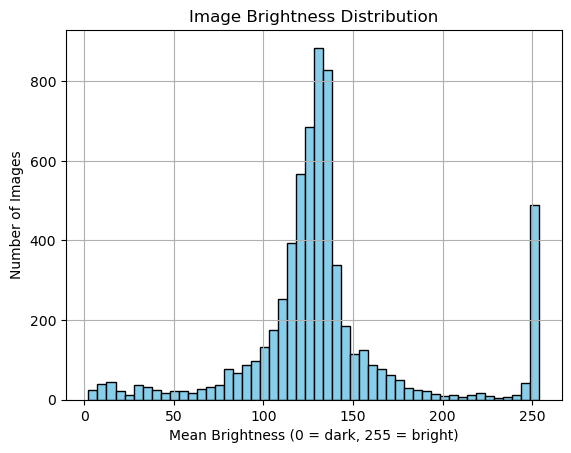

Filtering in progress
Finished image filtering
After filtering: 5,625
Database Images:
Before filtering: 96,586


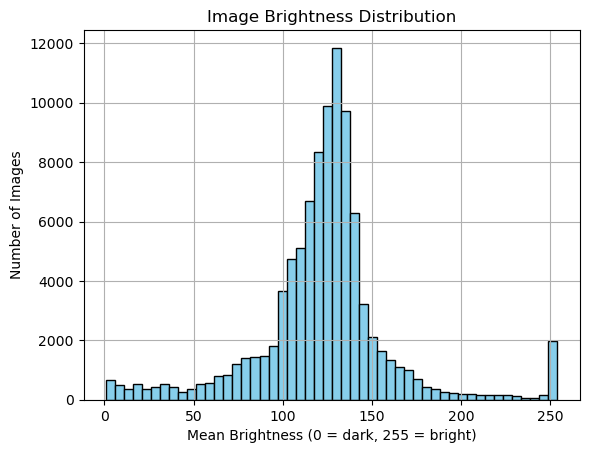

Filtering in progress
Finished image filtering
After filtering: 89,088


In [13]:
### Image filter *************************************************************************

print("Query Images:")
image_pose_path = os.path.join(query_output_root, "image_pose.txt")
filtered_image_pose_path = os.path.join(query_output_root, "filtered_image_pose.txt")
filter_images(query_output_root, image_pose_path, filtered_image_pose_path)

print("Database Images:")
image_pose_path = os.path.join(database_output_root, "image_pose.txt")
filtered_image_pose_path = os.path.join(database_output_root, "filtered_image_pose.txt")
filter_images(database_output_root, image_pose_path, filtered_image_pose_path)


In [14]:
### Plot poses and places ****************************************************************

GRID_SIZE = 4

filtered_image_pose_path = os.path.join(query_output_root, "filtered_image_pose.txt")
image_pose_place_path = os.path.join(query_output_root, "image_pose_place.txt")
generate_place_ids(filtered_image_pose_path, image_pose_place_path, GRID_SIZE, has_header=True)
#generate_place_ids_dbscan(filtered_image_pose_path, image_pose_place_path, eps=4.0, min_samples=1, has_header=True)
#plot_poses(query_output_root, avg_pose_file_name)
#plot_place_ids(image_pose_place_path, GRID_SIZE)


filtered_image_pose_path = os.path.join(database_output_root, "filtered_image_pose.txt")
image_pose_place_path = os.path.join(database_output_root, "image_pose_place.txt")
generate_place_ids(filtered_image_pose_path, image_pose_place_path, GRID_SIZE, has_header=True)
#generate_place_ids_dbscan(filtered_image_pose_path, image_pose_place_path, eps=4.0, min_samples=1, has_header=True)
#plot_poses(database_output_root, avg_pose_file_name)
#plot_place_ids(image_pose_place_path, GRID_SIZE)

print("Finished generating place_ids")


Processed 5624 entries with 37 unique place_ids.
Processed 89087 entries with 38 unique place_ids.
Finished generating place_ids


In [12]:
### Dataset split ************************************************************************

query_input_file = '/home/jovyan/data/VPR/LW/Query/image_pose_place.txt'
query_input_file_t = '/home/jovyan/data/VPR/LW/Query/image_pose_place_t.txt'
transform_camera_poses_to_base(query_input_file, query_input_file_t)
split_dataset(query_input_file_t, dataset_root, 'Query','train_query.txt', 'test_query.txt', 'val_query.txt')

database_input_file = '/home/jovyan/data/VPR/LW/Database/image_pose_place.txt'
database_input_file_t = '/home/jovyan/data/VPR/LW/Database/image_pose_place_t.txt'
transform_camera_poses_to_base(database_input_file, database_input_file_t)
split_dataset(database_input_file_t, dataset_root, 'Database', 'train_database.txt', 'test_database.txt', 'val_database.txt')

pos_dist_thr = 0.25
convert_txts_to_mat(dataset_root, pos_dist_thr)

merged_pose_file = '/home/jovyan/data/VPR/LW/image_pose_place.txt'
merge_query_database(query_input_file_t, database_input_file_t, merged_pose_file)

print("Finished dataset split")


Transformed poses saved to: /home/jovyan/data/VPR/LW/Query/image_pose_place_t.txt
Transformed poses saved to: /home/jovyan/data/VPR/LW/Database/image_pose_place_t.txt
Saved train data to /home/jovyan/data/VPR/LW/lw_train.mat
Saved val data to /home/jovyan/data/VPR/LW/lw_val.mat
Saved test data to /home/jovyan/data/VPR/LW/lw_test.mat
Finished dataset split


In [ ]:
### Ground truth generation **************************************************************

camera_matching = True
task_matching = False
date_matching = False

POSITIVE_DISTANCE_THRESHOLD = 2
NEGATIVE_DISTANCE_THRESHOLD = 10.0

triplets = generate_triplets_by_pose(image_pose_place_path, camera_matching, task_matching, date_matching, POSITIVE_DISTANCE_THRESHOLD, NEGATIVE_DISTANCE_THRESHOLD)
#triplets = generate_triplets_by_place(image_pose_place_path, camera_matching, task_matching, date_matching)

with open(gt_path, "w") as f:
    f.write("anchor positive negative\n")
    for anchor, positive, negative in triplets:
        f.write(f"{anchor} {positive} {negative}\n")

print("Finished ground truth generation")


In [ ]:
### Ground truth visualization ***********************************************************

triplets = []
with open(gt_path, 'r') as f:
    for i, line in enumerate(f):
        if not line.strip() or line.startswith("anchor"):
            continue
        if i >= 100:
            break
        anchor, positive, negative = line.strip().split()
        triplets.append((anchor, positive, negative))

for idx, (anchor, positive, negative) in enumerate(triplets):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    for j, img_path in enumerate([anchor, positive, negative]):
        ax = axes[j]
        full_path = os.path.join(dataset_root, img_path)
        img = mpimg.imread(full_path)
        ax.imshow(img)
        ax.axis('off')
        if j == 0:
            ax.set_title("Anchor")
        elif j == 1:
            ax.set_title("Positive")
        else:
            ax.set_title("Negative")
    plt.show()

    display(Markdown(
        f"**Anchor:** `{anchor}`  \n"
        f"**Positive:** `{positive}`  \n"
        f"**Negative:** `{negative}`"
    ))